## Import libraries

In [1]:
import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, Activation, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D

In [2]:
batch_size = 64
IMG_LEN = 224

## Load data

In [3]:
dataset_name = "stanford_dogs"
(ds_train, ds_test), ds_info = tfds.load(
    dataset_name, split=["train", "test"], with_info=True, as_supervised=True
)
NUM_CLASSES = ds_info.features["label"].num_classes

Shuffling and writing examples to /root/tensorflow_datasets/stanford_dogs/0.2.0.incompleteO3D3FC/stanford_dogs-train.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/stanford_dogs/0.2.0.incompleteO3D3FC/stanford_dogs-test.tfrecord


Dataset stanford_dogs downloaded and prepared to /root/tensorflow_datasets/stanford_dogs/0.2.0. Subsequent calls will reuse this data.


In [4]:
size = (IMG_LEN, IMG_LEN)
ds_train = ds_train.map(lambda image, label: (tf.image.resize(image, size), label))
ds_test = ds_test.map(lambda image, label: (tf.image.resize(image, size), label))

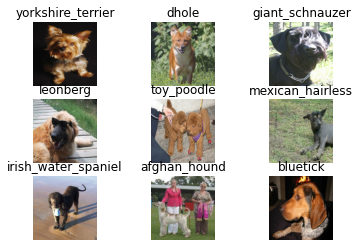

In [5]:
import matplotlib.pyplot as plt


def format_label(label):
    string_label = label_info.int2str(label)
    return string_label.split("-")[1]


label_info = ds_info.features["label"]
for i, (image, label) in enumerate(ds_train.take(9)):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image.numpy().astype("uint8"))
    plt.title("{}".format(format_label(label)))
    plt.axis("off")


## Data augmentation

In [6]:
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers

img_augmentation = Sequential(
    [
        preprocessing.RandomRotation(factor=0.4),
        preprocessing.RandomTranslation(height_factor=0.2, width_factor=0.2),
        preprocessing.RandomFlip(),
        preprocessing.RandomContrast(factor=0.2),
    ],
    name="img_augmentation",
)

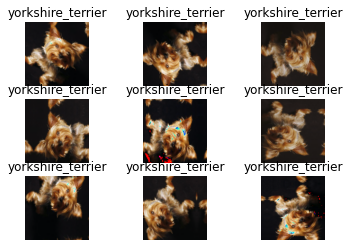

In [7]:
for image, label in ds_train.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        aug_img = img_augmentation(tf.expand_dims(image, axis=0))
        plt.imshow(aug_img[0].numpy().astype("uint8"))
        plt.title("{}".format(format_label(label)))
        plt.axis("off")

## Prepare input

In [8]:
# One-hot / categorical encoding
def input_preprocess(image, label):
    label = tf.one_hot(label, NUM_CLASSES)
    return image, label


ds_train = ds_train.map(
    input_preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE
)
ds_train = ds_train.batch(batch_size=batch_size, drop_remainder=True)
ds_train = ds_train.prefetch(tf.data.experimental.AUTOTUNE)

ds_test = ds_test.map(input_preprocess)
ds_test = ds_test.batch(batch_size=batch_size, drop_remainder=True)

## Model

In [18]:
from tensorflow.keras.applications import VGG19
from tensorflow.keras.callbacks import EarlyStopping

# Base VGG Model
inputs = layers.Input(shape=(IMG_LEN, IMG_LEN, 3))
x = img_augmentation(inputs)
base_model = VGG19(include_top=False, input_tensor=x, weights=None)

# adding regularization to every layer
regularizer = tf.keras.regularizers.l2(0.001)

for layer in model.layers:
    for attr in ['kernel_regularizer']:
        if hasattr(layer, attr):
          setattr(layer, attr, regularizer)

# Fine tune model
model = tf.keras.Sequential([
    base_model,
    GlobalAveragePooling2D(),
    BatchNormalization(),
    Dropout(0.5),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax'),
])

optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)

model.compile(
    optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"]
)

# Early Stopping
Early_Stopping = EarlyStopping(monitor='val_accuracy', patience=10, min_delta=0.001, mode='auto')

# model.summary()

history = model.fit(ds_train, epochs=100, validation_data=ds_test, verbose=2, callbacks=[Early_Stopping])

Epoch 1/100
187/187 - 104s - loss: 4.7939 - accuracy: 0.0099 - val_loss: 4.7816 - val_accuracy: 0.0062
Epoch 2/100
187/187 - 102s - loss: 4.7599 - accuracy: 0.0120 - val_loss: 4.7676 - val_accuracy: 0.0119
Epoch 3/100
187/187 - 101s - loss: 4.7137 - accuracy: 0.0160 - val_loss: 4.7122 - val_accuracy: 0.0209
Epoch 4/100
187/187 - 102s - loss: 4.6312 - accuracy: 0.0202 - val_loss: 4.7661 - val_accuracy: 0.0105
Epoch 5/100
187/187 - 101s - loss: 4.5627 - accuracy: 0.0243 - val_loss: 4.5207 - val_accuracy: 0.0238
Epoch 6/100
187/187 - 101s - loss: 4.5028 - accuracy: 0.0276 - val_loss: 4.4802 - val_accuracy: 0.0322
Epoch 7/100
187/187 - 101s - loss: 4.4785 - accuracy: 0.0297 - val_loss: 4.4541 - val_accuracy: 0.0315
Epoch 8/100
187/187 - 101s - loss: 4.4442 - accuracy: 0.0307 - val_loss: 4.5419 - val_accuracy: 0.0225
Epoch 9/100
187/187 - 101s - loss: 4.4184 - accuracy: 0.0333 - val_loss: 4.5777 - val_accuracy: 0.0223
Epoch 10/100
187/187 - 101s - loss: 4.3907 - accuracy: 0.0330 - val_loss:

## Learning Curve

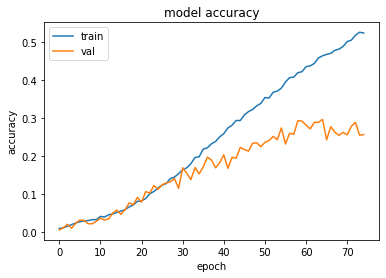

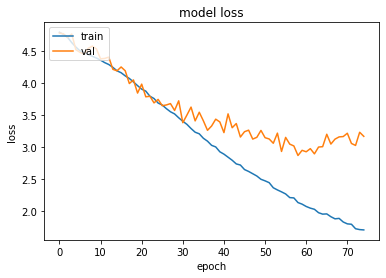

In [19]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()